In [1]:
import pandas as pd
import numpy as np

In [2]:
from collections import defaultdict
from spacy.util import minibatch
from spacy.util import compounding
import spacy
import os
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from collections import Counter
import plotly.figure_factory as ff
import plotly.express as px
from plotly import graph_objs as go
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


c:\Users\karth\anaconda3\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]


In [4]:
import plotly.io as pio
pio.renderers


Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [5]:
pio.renderers.default = "notebook_connected"


In [3]:
TD_df = pd.read_csv("TD_dataset_clean.csv", index_col=0)

# Drop NaN values and reset index of dataframe
TD_df = TD_df[TD_df['text'].notna()]
TD_df = TD_df.reset_index()
TD_df.drop(columns=["index"], inplace=True)


In [5]:
TD_df

,text,label
0,we didnt have time to do automated tests or gh...,1
1,user storyas a sre i would like to know that ...,1
8,background a while ago we had to change our bu...,1
10,as a developer\ri need a badge in readmemd fil...,1
12,subtasks\r refactor the imports\r export th...,1
...,...,...
126298,id like for us to add at least one test where ...,1
126299,some of the spikes on kahuna graphs seem to be...,1
126300,in gitlab by warsaw on dec nice if youre g...,1
126302,we have pretty similar code in scattered acros...,1


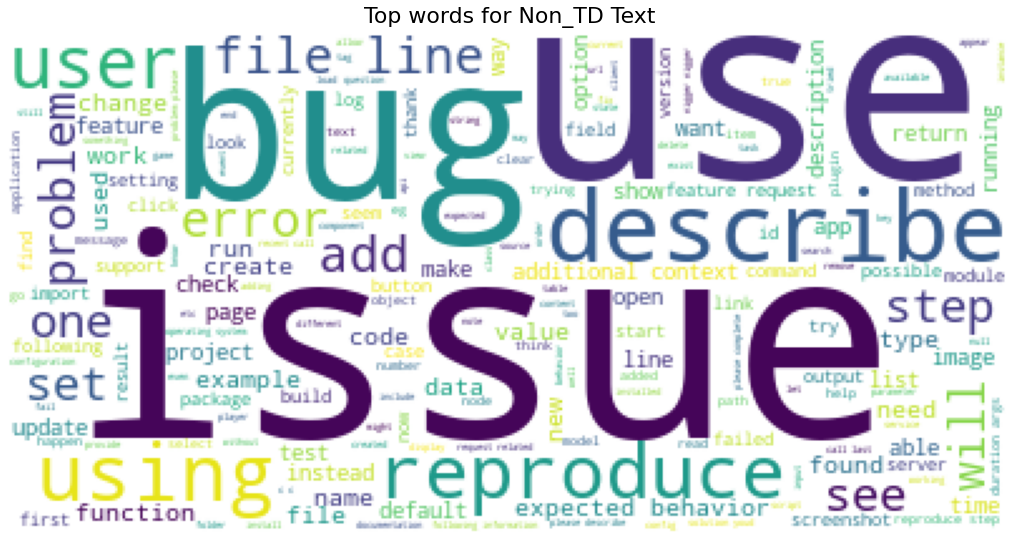

In [12]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(
    ' '.join(text for text in TD_df.loc[TD_df['label'] == 0, 'text']))
plt.figure(figsize=(18, 10))
plt.title('Top words for Non_TD Text',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


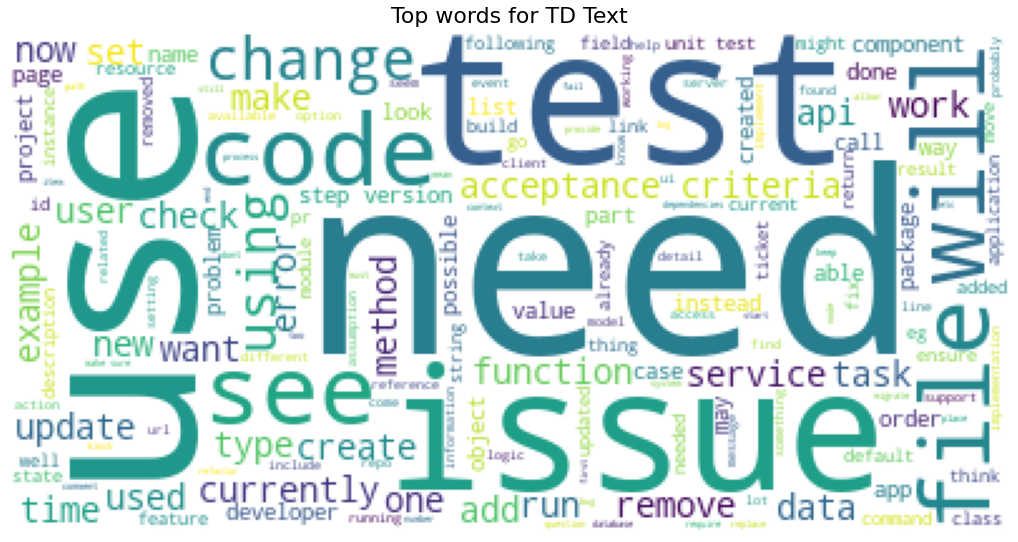

In [13]:
wc = WordCloud(
    background_color='white',
    max_words=200,
)
wc.generate(
    ' '.join(text for text in TD_df.loc[TD_df['label'] == 1, 'text']))
plt.figure(figsize=(18, 10))
plt.title('Top words for TD Text',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


In [36]:
top_debt_words = wc.generate(
    ' '.join(text for text in TD_df.loc[TD_df['label'] == 1, 'text']))


In [41]:
top_debt_words.words_

{'need': 1.0,
 'use': 0.836081887972704,
 'test': 0.6878021040659653,
 'issue': 0.5615581461472846,
 'code': 0.5526727324424225,
 'will': 0.5437873187375604,
 'see': 0.5076059141313619,
 'file': 0.48457492180835937,
 'change': 0.48372192209269266,
 'using': 0.41612169462610177,
 'acceptance criteria': 0.4075916974694342,
 'add': 0.3982797839067387,
 'user': 0.3832101222632926,
 'currently': 0.3783053738982087,
 'create': 0.3731873756042081,
 'update': 0.3633067955644015,
 'work': 0.3588996303667899,
 'used': 0.3559141313619562,
 'remove': 0.35136479954506683,
 'one': 0.3494455501848166,
 'run': 0.32847597384134203,
 'make': 0.3123400625533125,
 'data': 0.3080750639749787,
 'service': 0.3075063974978675,
 'function': 0.2911572362809212,
 'error': 0.28234290588569805,
 'api': 0.2816320727893091,
 'new': 0.2696900767699744,
 'set': 0.26883707705430765,
 'method': 0.26243957918680694,
 'type': 0.25582883139038953,
 'example': 0.2543360818879727,
 'task': 0.25149274950241685,
 'check': 0.24

In [16]:
TD_df['text_len'] = TD_df['text'].apply(lambda x: len(x.split(' ')))
TD_df.head()


,text,label,text_len
0,we didnt have time to do automated tests or gh...,1,37
1,user storyas a sre i would like to know that ...,1,71
2,please explain the process of having a backup ...,0,14
3,currently the first parse error in a codl docu...,0,24
4,please use this to only for bug reports for qu...,0,918


In [18]:
TD_df["text_len"].describe()

count    126306.000000
mean        108.725120
std         552.357209
min           1.000000
25%          21.000000
50%          47.000000
75%          98.000000
max      118680.000000
Name: text_len, dtype: float64

In [20]:
balance_counts = TD_df.groupby('label')['label'].agg('count').values
balance_counts


array([70662, 55644], dtype=int64)

In [21]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Non-TD'],
    y=[balance_counts[0]],
    name='Non-TD',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['TD'],
    y=[balance_counts[1]],
    name='TD',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by label</span>'
)
fig.show()


In [22]:
Non_TD_df = TD_df[TD_df['label'] == 0]['text_len'].value_counts().sort_index()
TD_df1 = TD_df[TD_df['label'] == 1]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=Non_TD_df.index,
    y=Non_TD_df.values,
    name='Non_TD',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=TD_df1.index,
    y=TD_df1.values,
    name='TD',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Message length</span>'
)
fig.update_xaxes(range=[0, 300])
fig.show()


In [23]:
from nltk.util import ngrams
from plotly import tools
import plotly.offline as py


In [24]:
#Gram analysis on Training set- Bigram and Trigram
stopword = set(stopwords.words('english'))


def gram_analysis(data, gram):
    tokens = [t for t in data.lower().split(
        " ") if t != "" if t not in stopword]
    ngrams = zip(*[tokens[i:] for i in range(gram)])
    final_tokens = [" ".join(z) for z in ngrams]
    return final_tokens


#Create frequency grams for analysis

def create_dict(data, grams):
    freq_dict = defaultdict(int)
    for sentence in data:
        for tokens in gram_analysis(sentence, grams):
            freq_dict[tokens] += 1
    return freq_dict


def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["n_gram_words"].values[::-1],
        x=df["n_gram_frequency"].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace


def create_new_df(freq_dict,):
    freq_df = pd.DataFrame(sorted(freq_dict.items(), key=lambda z: z[1])[::-1])
    freq_df.columns = ['n_gram_words', 'n_gram_frequency']
   
    trace = horizontal_bar_chart(freq_df[:20], 'orange')
    return trace


def plot_grams(trace_zero, trace_one):
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                              subplot_titles=["Frequent words of Non_TD ",
                                              "Frequent words of TD"])
    fig.append_trace(trace_zero, 1, 1)
    fig.append_trace(trace_ones, 1, 2)
    fig['layout'].update(height=1200, width=900,
                         paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')


In [25]:
TD_df_zero = TD_df[TD_df['label'] == 0]
TD_df_ones= TD_df[TD_df['label'] == 1]

In [31]:
print("Bi-gram analysis")
freq_df_zero=create_dict(TD_df_zero["text"],2)

Bi-gram analysis


In [32]:
trace_zero = create_new_df(freq_df_zero)
freq_df_ones = create_dict(TD_df_ones["text"], 2)
trace_ones = create_new_df(freq_df_ones)


In [33]:
plot_grams(trace_zero, trace_ones)


c:\Users\karth\anaconda3\envs\test\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [34]:
print("Tri-gram analysis")
freq_df_zero = create_dict(TD_df_zero["text"], 3)
trace_zero=create_new_df(freq_df_zero)
freq_df_ones = create_dict(TD_df_ones["text"], 3)
trace_ones=create_new_df(freq_df_ones)
plot_grams(trace_zero,trace_ones)

Tri-gram analysis


c:\Users\karth\anaconda3\envs\test\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

